# Persistence algorithm 을 이용한 forecasting 

- Persistence Algorithm : last value 를 next value 로 예측에 사용


- 약간의 noise 를 추가한 seasonality 와 trend 가 있는 인공 합성 time series 이용 

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
np.random.seed(101)

아래 코드는 다음과 같은 작업을 수행합니다:

trend 함수를 정의하여 주어진 시간(time)에 대한 선형 추세를 계산합니다. 기울기(slope) 인자를 통해 추세의 강도를 조절할 수 있습니다.  

seasonal_pattern 함수를 정의하여 시간(season_time)에 대한 계절성 패턴을 생성합니다. 이 예에서는 코사인 함수와 지수 함수를 사용하여 임의의 패턴을 만듭니다.  

seasonality 함수를 정의하여 시간(time)에 대해 주기적으로 반복되는 계절성 패턴을 생성합니다. 주기(period), 진폭(amplitude), 및 위상(phase) 인자를 사용하여 계절성 패턴의 특성을 조절할 수 있습니다.  

noise 함수를 정의하여 시간(time)에 대한 노이즈를 생성합니다. 노이즈 수준(noise_level)과 시드(seed) 인자를 사용하여 노이즈의 특성을 조절할 수 있습니다.  

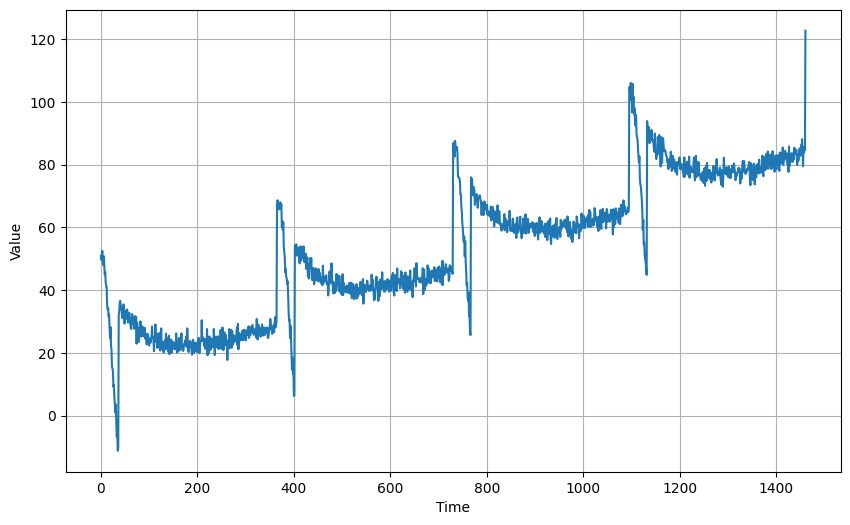

In [46]:
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """임의의 pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """매 기간 마다 동일 pattern 반복"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")   # 4년 동안의 시간 데이터를 생성
baseline = 10          # 기본값
series = trend(time, 0.1)      # 추세 시계열 data 
amplitude = 40
slope = 0.01
noise_level = 2

# 기본값, 추세, 계절성 및 노이즈를 결합하여 시계열 데이터(series)를 생성
series = baseline + 0.05 * time + \
         seasonality(time, period=365, amplitude=amplitude) 

# noise 추가
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plt.plot(series)
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()

In [47]:
series.shape

(1461,)

### 위에서 생성한 time series 를 train 와 validation set 으로 분할

시간(time) 및 시계열 데이터(series)를 split_time을 기준으로 훈련 세트와 테스트 세트로 나눕니다.  
그래프에서 훈련 세트는 파란색 선으로, 테스트 세트는 주황색 선으로 표시됩니다. 

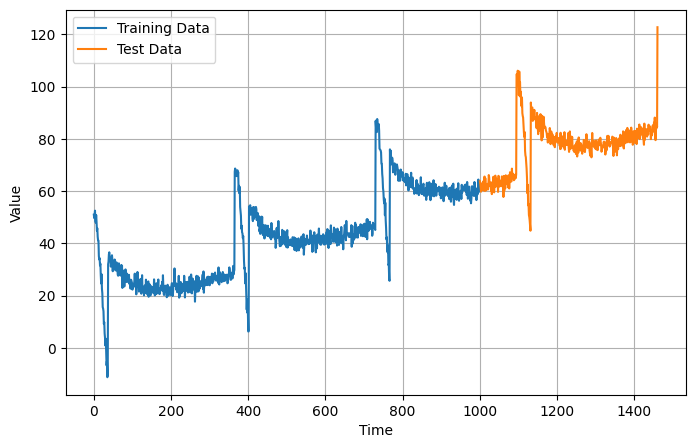

In [48]:
# 데이터를 훈련 세트와 테스트 세트로 분할하는 시점
split_time = 1000

# 훈련 데이터 생성: 분할 시점까지의 시간과 시계열 데이터
time_train = time[:split_time]
X_train = series[:split_time]

# 테스트 데이터 생성: 분할 시점 이후의 시간과 시계열 데이터
time_test = time[split_time:]
X_test = series[split_time:]

plt.figure(figsize=(8, 5))

# 훈련 데이터 시각화
plt.plot(time_train, X_train, label='Training Data')
# 테스트 데이터 시각화
plt.plot(time_test, X_test, label='Test Data')

plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

## Naive Forecast

- last value 를 prediction 으로 사용 -> one-step behind prediction  

나이브 포캐스트(Naive Forecast) 방법은 매우 단순한 시계열 예측 방법입니다. 이 방법은 시계열 데이터의 현재 값을 바로 다음 시점의 예측값으로 사용합니다. 즉, 시간 
t에서의 값을 t+1에서의 값으로 예측하는 것입니다. 이렇게 하면, 예측은 항상 실제 값의 "한 스텝 뒤"에 위치하게 됩니다.   

예를 들어, split_time이 1000이라면, series[999]의 값이 첫 번째 예측값이 되어, 시간 1000에 대한 예측으로 사용됩니다. 이는 우리가 실제로 관측한 마지막 값(series[999])을 다음 시점(series[1000])의 예측값으로 사용하겠다는 것을 의미합니다.

`naive_forecast = series[split_time-1:-1]` 코드에서 split_time-1을 사용하는 것은 데이터를 분할하는 시점 바로 이전의 값에서 시작하여 예측을 생성하기 위함입니다. 이렇게 설정함으로써, 예측 시리즈(naive_forecast)는 실제 데이터 시리즈의 마지막 값 직전까지의 값을 포함하게 됩니다.

In [49]:
split_time

1000

In [50]:
# split_time 바로 이전 시점부터 시작해서 series 시리즈의 끝에서 두 번째 요소까지를 포함하는 새로운 시리즈를 생성
naive_forecast = series[split_time-1:-1]
print(naive_forecast[-5:])

[79.517105 84.591385 83.893135 85.75651  84.569595]


실제값이 naive_forecast 값과 유사한지 확인해 봅니다.

In [51]:
print(X_test[-5:])

[ 84.591385  83.893135  85.75651   84.569595 122.72309 ]


테스트 세트에 대한 원래 시계열 데이터와 naive forecasting을 그래프로 그립니다.

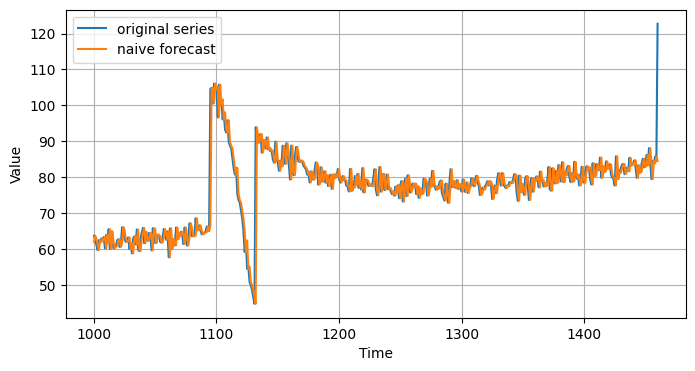

In [52]:
plt.figure(figsize=(8, 4))
plt.plot(time_test, X_test, label='original series')
plt.plot(time_test, naive_forecast, label='naive forecast')
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()

naive forecast 가 one-step behind 인지 그래프상으로 구별 어려우므로 validation period 의 앞부분으로 zoom in.

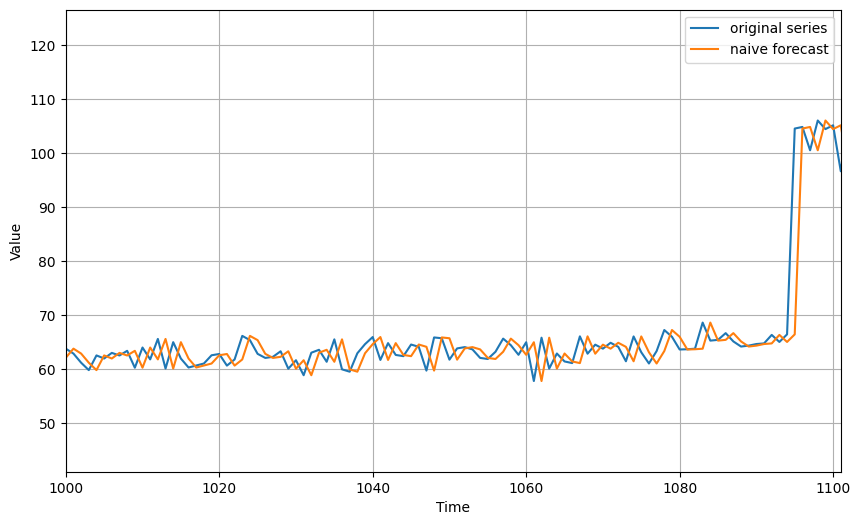

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(time_test, X_test, label='original series')
plt.plot(time_test, naive_forecast, label='naive forecast')
plt.xlabel("Time")
plt.ylabel("Value")
plt.xlim(1000, 1101)
plt.grid(True)
plt.legend()

- naive forecast 가 1 step behind 지연되어 time series 를 그대로 재현하고 있음을 알 수 있습니다.

### naive forecast 와 validation period 값 간의 차이를  mse 와 mae 로 계산

테스트 세트와 naive forecasting 사이의 평균 제곱 오차(MSE)와 평균 절대 오차(MAE)를 계산합니다.

In [54]:
print(mean_squared_error(X_test, naive_forecast))
print(mean_absolute_error(X_test, naive_forecast))

20.167190551757812
2.5842602252960205


### 위의 값을 모든 prediction model 의 최소 성능의 baseline 으로 한다. 

# Real Data를 이용한 Naive Forecasting

parser 함수는 인자로 문자열 x를 받아서 datetime.strptime 함수를 사용하여 해당 문자열을 '%Y-%m' 형식의 datetime 객체로 변환합니다.  
```
"Month","Sales"
"1-01",266.0
"1-02",145.9
"1-03",183.1
"1-04",119.3
```

인터넷에서 샴푸 판매량 데이터셋(CSV 파일)을 읽어들이고, Pandas DataFrame 객체로 변환합니다. 
- parse_dates 매개변수를 사용하여 첫 번째 열(0)을 날짜로 처리하도록 설정합니다.
- date_parser 매개변수를 사용하여 앞서 정의한 parser 함수를 날짜 변환에 사용합니다.
- index_col 매개변수를 사용하여 날짜 열을 DataFrame의 인덱스로 설정합니다.
- header 매개변수를 사용하여 첫 번째 행을 열 이름으로 사용하도록 설정합니다.

In [55]:
# 데이터 불러오기
url = "https://raw.githubusercontent.com/ironmanciti/Time_Series_Lecture/main/datasets/shampoo-sales.csv"
series = pd.read_csv(url, header=0)
series.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


In [56]:
# 인덱스를 '190'을 추가하여 날짜 형식으로 변환
series['Month'] = pd.to_datetime('190' + series['Month'], format='%Y-%m')

# 'Month' 열을 새로운 인덱스로 설정
series.set_index('Month', inplace=True)

# 확인
series.head()

,Sales
Month,
1901-01-01,266.0
1901-02-01,145.9
1901-03-01,183.1
1901-04-01,119.3
1901-05-01,180.3


<Axes: xlabel='Month'>

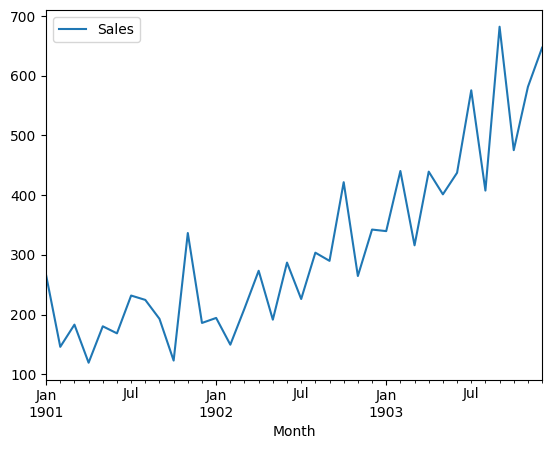

In [57]:
series.plot()

### Train / Test set 분리

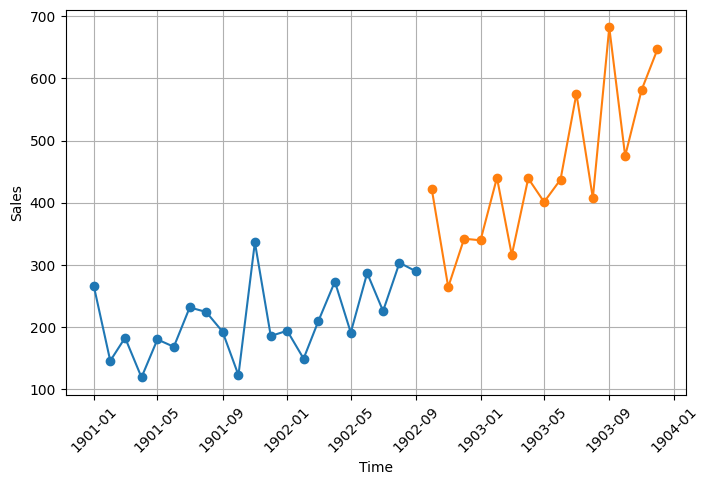

In [58]:
split_time = int(len(series) * 0.6)

X_train = series[:split_time]

X_test = series[split_time:]

plt.figure(figsize=(8, 5))
plt.plot(series.index[:split_time], X_train, marker='o')
plt.plot(series.index[split_time:], X_test, marker='o')
plt.xlabel("Time")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Persistence Algorithm 정의

이 함수는 시계열 데이터에서 각 시점의 값을 다음 시점의 예측값으로 사용하는 모델입니다. 여기서 사용하는 주요 개념은 다음과 같습니다:

- **series**: 이는 시간에 따라 변하는 데이터를 담고 있는 Pandas의 Series나 DataFrame 객체입니다. 예를 들어, 매일의 온도나 매월의 판매량과 같은 시계열 데이터가 여기에 해당합니다.
- **split_time**: 이 값은 전체 시계열 데이터를 두 부분, 즉 학습 데이터와 테스트 데이터로 나누는 지점의 인덱스를 나타냅니다. 예를 들어, 전체 데이터가 100일치 있고 `split_time`이 70이라면, 처음 70일은 학습 데이터로, 나머지 30일은 테스트 데이터로 사용됩니다.

이 모델의 핵심 아이디어는 매우 단순합니다. 각 시점에서 바로 이전 시점의 실제 값을 현재 시점의 예측값으로 사용합니다. 함수는 테스트 데이터 기간 동안의 예측값을 제공하는데, 이는 각 시점에서 바로 앞 시점의 데이터 값을 의미합니다.

In [59]:
def model_persistence(series, split_time):
    """
    Persistence 모델을 구현한 함수입니다.
    이 모델은 간단히 이전 시점의 데이터 값을 현재 시점의 예측값으로 사용합니다.
    
    매개변수:
    - series: Pandas Series 또는 DataFrame 객체. 시계열 데이터를 포함하고 있습니다.
    - split_time: int. 시계열 데이터를 학습 데이터와 테스트 데이터로 나누는 기준점(인덱스)입니다.
    
    반환값:
    - 테스트 세트에 해당하는 시계열 데이터의 이전 시점 값들을 반환합니다.
      즉, split_time 바로 이전의 데이터부터 시작하여, series의 끝에서 두 번째 데이터까지 포함합니다.
    """
    return series[split_time-1:-1]

### 예측 및 평가

In [60]:
prediction = model_persistence(series, split_time)
prediction[-5:].values

array([[575.5],
       [407.6],
       [682. ],
       [475.3],
       [581.3]])

In [61]:
X_test[-5:].values

array([[407.6],
       [682. ],
       [475.3],
       [581.3],
       [646.9]])

In [62]:
prediction = model_persistence(series, split_time)

test_score = mean_squared_error(X_test.values, prediction.values)
print('Test MSE: {:,.3f}'.format(test_score))

# RMSE 계산
rmse = np.sqrt(test_score)

print("RMSE:", rmse)

Test MSE: 18,168.136
RMSE: 134.78922805625083


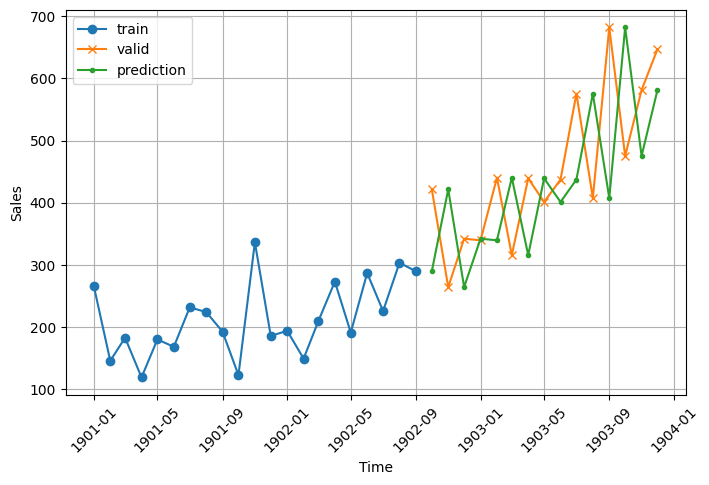

In [63]:
# 시계열 데이터 시각화 설정
plt.figure(figsize=(8, 5))

# 훈련 데이터 부분을 그래프에 그립니다. 훈련 데이터는 'train' 라벨로 표시되며, split_time 이전까지의 데이터 포인트를 사용합니다.
plt.plot(series.index[:split_time], X_train, label='train', marker='o')

# 검증 데이터 부분을 그래프에 그립니다. 검증 데이터는 'valid' 라벨로 표시되며, split_time 이후의 데이터 포인트를 사용합니다.
plt.plot(series.index[split_time:], X_test, label='valid', marker='x')

# 예측 데이터 부분을 그래프에 그립니다. 예측 데이터는 'prediction' 라벨로 표시되며, 검증 데이터와 동일한 시점에 위치합니다.
plt.plot(series.index[split_time:], prediction, label='prediction', marker='.')

# x축과 y축의 라벨을 설정하고, x축의 라벨을 45도 기울여서 모든 날짜 라벨이 겹치지 않게 표시합니다.
plt.xlabel("Time")
plt.ylabel("Sales")
plt.xticks(rotation=45)

# 그리드를 추가하고, 범례를 표시하여 데이터 세트를 구분할 수 있도록 합니다.
plt.grid(True)
plt.legend()
plt.show()